# Обработка изображений с использованием Python и OpenCV

## Загрузка и отображение изображения

Для работы с изображениями сначала нужно загрузить их в программу. Для этого используется метод `cv2.imread()`. Загрузим изображение и выведем его:

```python
import cv2
import matplotlib.pyplot as plt

# Загрузка изображения
image = cv2.imread('example_image.jpg')

# Отображение изображения
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
```

Мы используем `cv2.cvtColor()` для правильного отображения цветов.

## Основные операции

### 1. Размытие (Blurring)

Размытие используется для сглаживания изображения. Это полезно, например, для уменьшения шумов.

```python
# Применение размытия
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
```

### 2. Обнаружение краев (Edge Detection)

Обнаружение краев выявляет переходы между областями разного цвета. Одним из методов является оператор Гаусса:

```python
# Обнаружение краев
edges = cv2.Canny(image, 100, 200)
```

### 3. Изменение размера (Resizing)

Изменение размера полезно для адаптации изображения под требуемые размеры.

```python
# Изменение размера
resized_image = cv2.resize(image, (300, 200))
```

## Цветовые палитры

Цветовые палитры влияют на восприятие изображения. Рассмотрим основные:

### 1. RGB (Red, Green, Blue)

Стандартная цветовая модель. Каждый пиксель представлен тремя значениями: R, G и B.

### 2. Grayscale

Изображение состоит только из оттенков серого. Применение:

```python
# Преобразование в оттенки серого
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
```

### 3. HSV (Hue, Saturation, Value)

Модель, которая разделяет цвет на три компонента: оттенок (Hue), насыщенность (Saturation) и яркость (Value).

```python
# Преобразование в HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
```

### 4. Цветовые фильтры

Применение цветовых фильтров может подчеркнуть определенные цвета в изображении:

```python
# Фильтр по цвету (например, синий)
blue_filter = cv2.inRange(image, (100, 0, 0), (140, 255, 255))
```

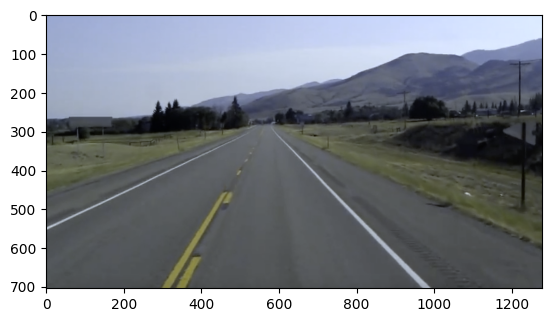

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image = cv2.cvtColor(cv2.imread("Datasets/test_image.jpg"), cv2.COLOR_BGR2XYZ)
plt.imshow(image)
plt.show()

In [2]:
lane_image = np.copy(image)
lane_image.shape

(704, 1279, 3)

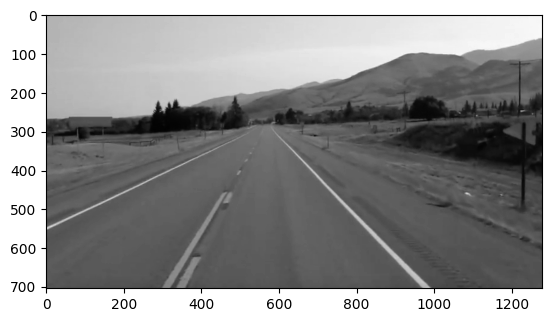

In [3]:
# Переведем в оттенки серого
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray, cmap='gray')
plt.show()

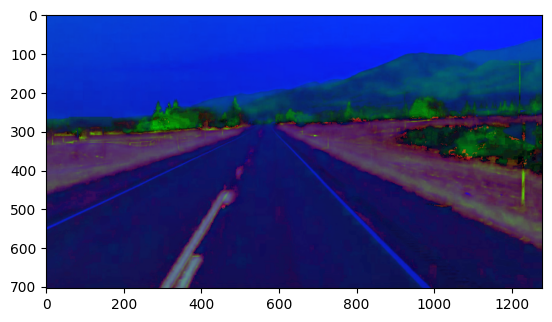

In [4]:
# Попробуем другой формат цветовой гаммы
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_image)
plt.show()

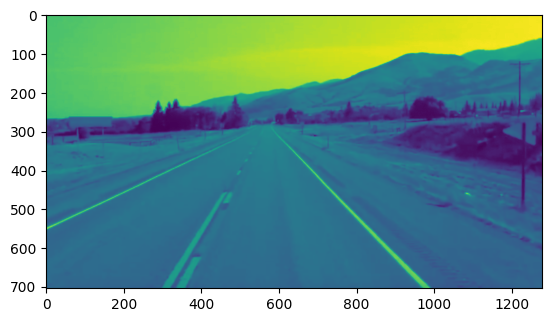

In [5]:
# Применим размытие по Гауссу для уменьшения шума
blur = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blur)
plt.show()

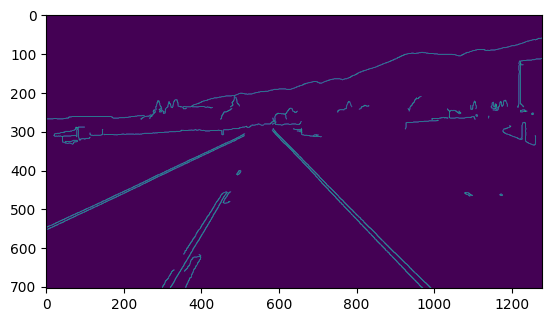

In [6]:
canny = cv2.Canny(blur, 50, 150)
plt.imshow(canny)
plt.show()

In [7]:
#  Все шаги упакуем в одну функцию, так будет удобнее
def Canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

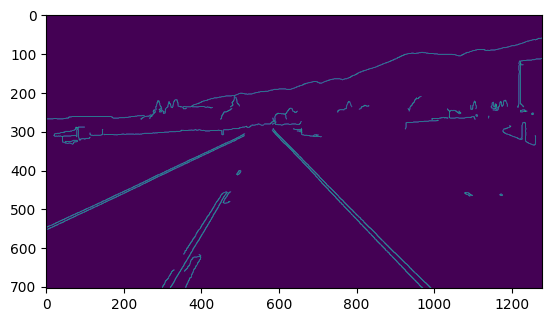

In [9]:
lane_image = np.copy(image)
canny = Canny(lane_image)
plt.imshow(canny)
plt.show()

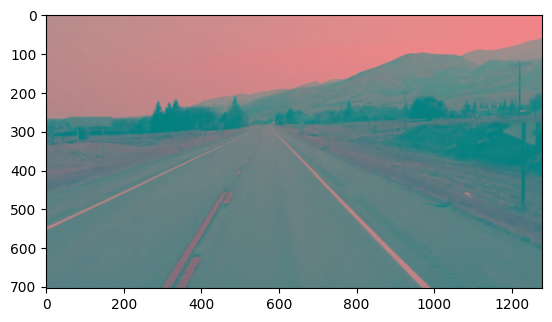

In [10]:
# Изменим цветовую гамму
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
plt.imshow(lab_image)
plt.show()

In [11]:
# Напишем функцию для поиска зоны интереса
# Применим побитовую операцию для выбора интересующей области

def region_of_interest(image):
    height = 700
    polygons = np.array([[(250, height), (1000, height), (600, 250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_region = cv2.bitwise_and(image, mask)
    return masked_region

In [12]:
# Функция, которая рисует линии в виде обнаруженных полос на черном изображении
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

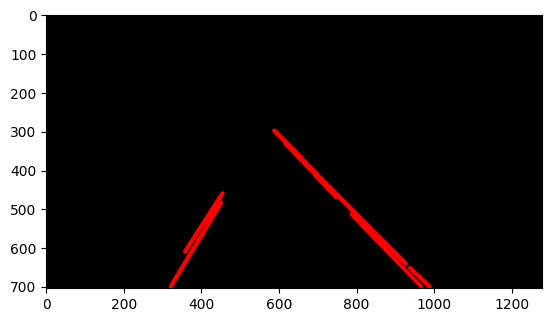

In [13]:
lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)

lines = cv2.HoughLinesP(cropped_image, 2, np.pi / 180, 100, np.array([]), 40, 5)
line_image = display_lines(lane_image, lines)

plt.imshow(line_image)
plt.show()

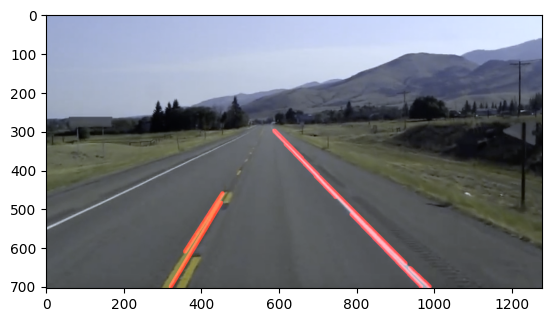

In [14]:
# Теперь объединим всё воедино
combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)
plt.imshow(combo_image)
plt.show()

In [15]:
# Добавим оптимизацию для уточнения определения полос движения

def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1 * (3 / 5))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [16]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)

        slope = parameters[0]
        intercept = parameters[1]

        if slope < 0:
            left_fit.append((slope, intercept))
        elif slope >= 0:
            right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)

    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)

    return np.array([left_line, right_line])

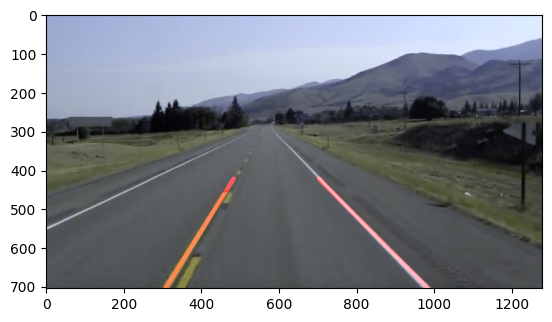

In [17]:
lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)

lines = cv2.HoughLinesP(cropped_image, 2, np.pi / 180, 100, np.array([]), 40, 5)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)

combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)

plt.imshow(combo_image)
plt.show()